In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

In [2]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
#i case==2 dname=data_C.... implement on our own if we want

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

print(v.shape)

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
(10000, 20)


## initialize

In [3]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 2
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-8.72876393e-02  2.04222126e-01]
 [-2.21489412e-01 -2.36964198e-01]
 [ 8.38211653e-01  5.94150244e-01]
 [ 3.96160518e-02  1.20136963e-01]
 [ 3.27912325e-01  5.31481557e-01]
 [ 4.29466985e-01 -5.52710538e-01]
 [ 1.17256826e-01  9.76087795e-02]
 [ 5.76885677e-01  3.77974741e-01]
 [-8.53501017e-01 -1.58554191e-01]
 [ 7.11674783e-01 -1.87006764e-01]
 [-2.30146526e-01  2.03387092e-01]
 [ 1.38535434e+00 -4.35452880e-01]
 [-2.46070853e-01  5.29254898e-02]
 [ 1.29034856e-01  2.23337160e-01]
 [ 4.00935791e-04  5.73002421e-01]
 [-3.04256178e-01 -3.54405060e-01]
 [-1.01067017e+00 -7.93431066e-01]
 [-3.67028188e-01  2.38846755e-01]
 [-5.39796281e-01  5.10944576e-02]
 [-4.53483232e-01  1.41941667e-01]]
a= [-1.00605956 -0.0850854  -0.6575091  -0.41392318 -0.55731957  0.12209994
  0.16117297 -0.3214583   0.14126068  0.57553201  0.02979552  0.10518219
 -0.0050578   0.4284531   0.56591768 -0.39197445 -0.6605412   0.00945954
  0.32336713 -0.28164852]
b= [0. 0.]


## Plotting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


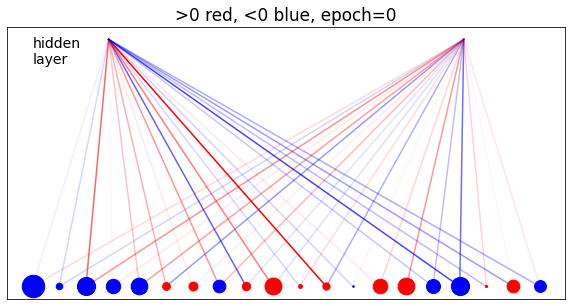

In [4]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [5]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 4
activate(v[k],w,b,GAP,info=True)

input= [0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
act= [-0.26465979  1.34505401]
prob= [0.43421858 0.79331984]
output= [0 0]


array([0, 0])

## Point 4:

If we simply use the activate function for the backward step of the contrastive divergence, we would generate vectors with 0s and 1s (activating a 1 for each component of the new vector, if a random generated number is under the probability calculated above). If we do so, however, for each 4 blocks of the vector there are $2^4$ possible states, while fot the way in which our data is structured (one-hot encoding) the ''real'' possible states are only 4: 0001,0010,0100,1000.    

Here is what I did:
- I defined a vector that contains all possible states, $s$
- for each entry of our data (a row with 20 elements) I divide it in blocks of 4;
- I compared each block of 4 with each state of s, to recognize to which state it corresponds;
- I compute the energy of the state as  $$E_{state}= \sum_{k \in block}[a_{k}+ \sum_{\nu}W_{k \nu}h_{\nu}]v_{k}$$
  where $v_{k}$ is (each time) the sub-vector of our real vector v constituded by 4 elements;

- I computed the Boltzmann's weights for each of the 4 states as $exp^{-E_{state}}$
- I calculated the normalized probability $p$.

Then, in order to have 4 intervals between 0 and 1, I calculated the cumulative probability for each state: $${C_{prob}}_i=\sum_{j\leq i}p_j$$.    
    
At this point, I have 4 levels that divide the gap 0-1 into 4 intervals. I generate a random number between 0 and 1 and, depending on which interval it belongs, I then generate the corresponding state of s.    
In this way, I generate 4 blocks at a time of the new "fantasy" vector (so I do it $5$ times), preserving the one-hot encoding structure.

In [6]:
s = np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
vtest = np.array([0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0])
print(vtest)
htest = np.array([0, 0])  


def activate_back(v,h,w,a,k,steps):
    
    e = np.zeros(4)
    
    for i in range(0,20,4):
        for j in range(len(s)):
            if np.array_equiv(v[i:i+4],s[j])==True:
                local_f = a[i:i+4]+np.dot(w[i:i+4,:],h)
                e[j]+= np.dot(local_f,v[i:i+4])
    bol = exp(-e)
    p = bol/bol.sum()
    #print(p)
    cprob = np.zeros(4)
    cprob[0] = p[0]
    for i in range(1,4):
        cprob[i]+=cprob[i-1]+p[i]
        
    vf = np.zeros(20)
    for i in range(0,20,4):
        x = np.random.random()
        if x<=cprob[0]:
            vf[i:i+4]=s[0]
        if cprob[0]<x<=cprob[1]:
            vf[i:i+4]=s[1]
        if cprob[1]<x<=cprob[2]:
            vf[i:i+4]=s[2]
        if cprob[2]<x<=cprob[3]:
            vf[i:i+4]=s[3]
            
    for i in range(0,3):
        if k == 500*i and steps==1:
            print('----initiating backward CD: k = ',k,'----')
            print('WEIGHTS[0] : ', w.T[0])
            print('EVALUATED ENERGIES = ',e, '\n') 
            print('PROBABILITY : ', p, '\n')                       #it starts to behave strangely after 4,5 epochs
            print('CUMULATIVE PROBABILITY : ', cprob, '\n\n')
            
    return(vf,cprob)

vf, cprob = activate_back(vtest,htest,w,a,1,1)
print(vf)
print(cprob)

[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
[0.21038277 0.49560682 0.63267459 1.        ]


## Energies

In [7]:
def E(v,h):
    ene = -(np.dot((np.dot(v,w)).T,h))-np.dot(a.T,v)-np.dot(b.T,h)
    return ene

# Training with ADAM and more steps of CD

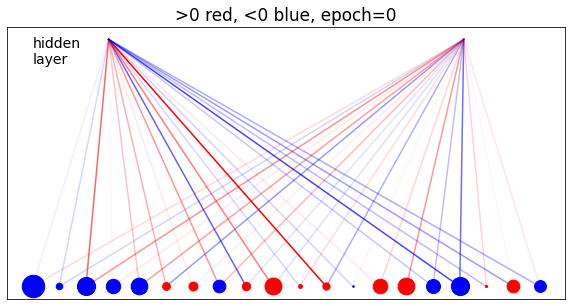

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-8.72876393e-02 -2.21489412e-01  8.38211653e-01  3.96160518e-02
  3.27912325e-01  4.29466985e-01  1.17256826e-01  5.76885677e-01
 -8.53501017e-01  7.11674783e-01 -2.30146526e-01  1.38535434e+00
 -2.46070853e-01  1.29034856e-01  4.00935791e-04 -3.04256178e-01
 -1.01067017e+00 -3.67028188e-01 -5.39796281e-01 -4.53483232e-01]
EVALUATED ENERGIES =  [-0.73538148  0.          1.00398512 -0.6605412 ] 

PROBABILITY :  [0.38716983 0.18557924 0.06799926 0.35925167] 

CUMULATIVE PROBABILITY :  [0.38716983 0.57274907 0.64074833 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [-8.72876393e-02 -2.21489412e-01  8.38211653e-01  3.96160518e-02
  3.27912325e-01  4.29466985e-01  1.17256826e-01  5.76885677e-01
 -8.53501017e-01  7.11674783e-01 -2.30146526e-01  1.38535434e+00
 -2.46070853e-01  1.29034856e-01  4.00935791e-04 -3.04256178e-01
 -1.01067017e+00 -3.67028188e-01 -5.39796281e-01 -4.53483232e-01]
EVALUATED ENERGIES =  [-0.

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-0.03936109 -0.26570081  0.78988109 -0.00383203  0.36077112  0.38094021
  0.07188674  0.59211444 -0.80469004  0.66567795 -0.27765047  1.34196869
 -0.21707691  0.08052243 -0.04422248 -0.26422215 -0.96228801 -0.4110573
 -0.58812791 -0.49732901]
EVALUATED ENERGIES =  [-0.37797605  0.          0.         -1.13262546] 

PROBABILITY :  [0.22235269 0.15236649 0.15236649 0.47291432] 

CUMULATIVE PROBABILITY :  [0.22235269 0.37471919 0.52708568 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-0.03153911 -0.27202273  0.78215001 -0.00925308  0.36484802  0.37332554
  0.0652184   0.60118668 -0.79665483  0.65877591 -0.28490361  1.33587437
 -0.21257162  0.07297049 -0.05001761 -0.25625002 -0.9542791  -0.41699912
 -0.59597049 -0.50331295]
EVALUATED ENERGIES =  [ 0.9173817   1.59019211 -0.27666671  0.44994234] 

PROBABILITY :  [0.15608926 0.07964806 0.51515944 0.24910324] 

CUMULATIVE PROBABILITY :  [0.15608926 0.23573732 0.

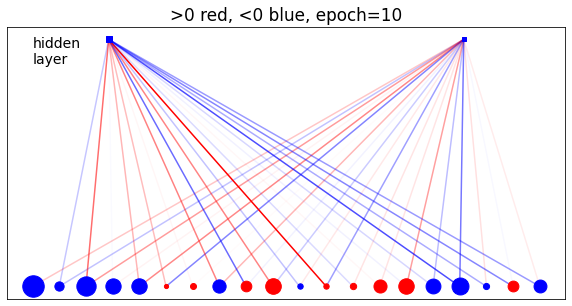

l_rate =  0.9090909090909092
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.00143337 -0.29272733  0.75006548 -0.02540109  0.37744713  0.34229465
  0.04399687  0.6456883  -0.76428099  0.63381939 -0.31453182  1.31761471
 -0.19363524  0.0421178  -0.07274701 -0.21322743 -0.92034181 -0.4357259
 -0.62825975 -0.5244051 ]
EVALUATED ENERGIES =  [ 0.         -0.02001369  0.          0.        ] 

PROBABILITY :  [0.2487429  0.25377131 0.2487429  0.2487429 ] 

CUMULATIVE PROBABILITY :  [0.2487429  0.50251421 0.7512571  1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.00143337 -0.29272733  0.75006548 -0.02540109  0.37744713  0.34229465
  0.04399687  0.6456883  -0.76428099  0.63381939 -0.31453182  1.31761471
 -0.19363524  0.0421178  -0.07274701 -0.21322743 -0.92034181 -0.4357259
 -0.62825975 -0.5244051 ]
EVALUATED ENERGIES =  [-0.35199999  0.          0.34181736 -1.26966496] 

PROBABILITY :  [0.21247739 0.14943113 0.10616752 0.53192396] 

CUMULATIVE PROBABILITY :

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.03722671 -0.31062837  0.7139852  -0.03979057  0.38324816  0.30658003
  0.02486661  0.69620244 -0.7308949   0.60717409 -0.34812299  1.30504563
 -0.19302253  0.00857067 -0.09501607 -0.16138428 -0.88325606 -0.44985008
 -0.6646818  -0.54694709]
EVALUATED ENERGIES =  [ 0.         -0.17700477  0.41754165  0.20683223] 

PROBABILITY :  [0.27281728 0.32564475 0.17969494 0.22184303] 

CUMULATIVE PROBABILITY :  [0.27281728 0.59846203 0.77815697 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.04293661 -0.31170728  0.70821239 -0.04093786  0.38433486  0.30096687
  0.02383922  0.70436864 -0.72531929  0.60324306 -0.35323512  1.30425486
 -0.19271388  0.00321541 -0.0972743  -0.15267694 -0.87717263 -0.45056183
 -0.67031888 -0.55018123]
EVALUATED ENERGIES =  [ 0.         -0.31202816  0.         -0.45417936] 

PROBABILITY :  [0.20238517 0.27649723 0.20238517 0.31873244] 

CUMULATIVE PROBABILITY :  [0.20238517 0.4788824  0

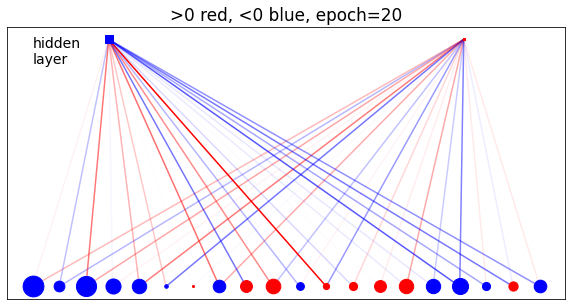

l_rate =  0.8333333333333337
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.06731101 -0.32275543  0.68607907 -0.04652145  0.3880461   0.279395
  0.01670572  0.73529711 -0.70078337  0.58850298 -0.37437721  1.29688848
 -0.19482945 -0.01717058 -0.10552503 -0.12130954 -0.85207208 -0.45383778
 -0.69360773 -0.56332903]
EVALUATED ENERGIES =  [ 0.         -1.02001523 -0.03478818  0.        ] 

PROBABILITY :  [0.17215742 0.47743332 0.17825185 0.17215742] 

CUMULATIVE PROBABILITY :  [0.17215742 0.64959073 0.82784258 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.06731101 -0.32275543  0.68607907 -0.04652145  0.3880461   0.279395
  0.01670572  0.73529711 -0.70078337  0.58850298 -0.37437721  1.29688848
 -0.19482945 -0.01717058 -0.10552503 -0.12130954 -0.85207208 -0.45383778
 -0.69360773 -0.56332903]
EVALUATED ENERGIES =  [ 1.2926119   0.30945359  0.         -1.3724165 ] 

PROBABILITY :  [0.04611795 0.12326797 0.16797484 0.66263924] 

CUMULATIVE PROBABILITY :  

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.09195348 -0.32398833  0.66279963 -0.0571938   0.38192772  0.25354143
  0.02005944  0.77317974 -0.67807891  0.57614038 -0.39481233  1.28917273
 -0.2057383  -0.04056856 -0.10733083 -0.08484255 -0.82403978 -0.44689951
 -0.72027164 -0.58020081]
EVALUATED ENERGIES =  [-0.43136604  0.85351601 -0.63881494  0.30113869] 

PROBABILITY :  [0.33468081 0.09260056 0.4118364  0.16088222] 

CUMULATIVE PROBABILITY :  [0.33468081 0.42728138 0.83911778 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.09606606 -0.32362316  0.6592481  -0.05795614  0.38191675  0.24934402
  0.0215953   0.77976574 -0.6746362   0.57444788 -0.39755269  1.28900942
 -0.20812809 -0.04357332 -0.10718974 -0.07893572 -0.81986959 -0.44285249
 -0.72447407 -0.58276435]
EVALUATED ENERGIES =  [ 0.93668167 -0.68995957  0.65213917 -0.17441376] 

PROBABILITY :  [0.09566084 0.48660379 0.12714796 0.29058741] 

CUMULATIVE PROBABILITY :  [0.09566084 0.58226463 0

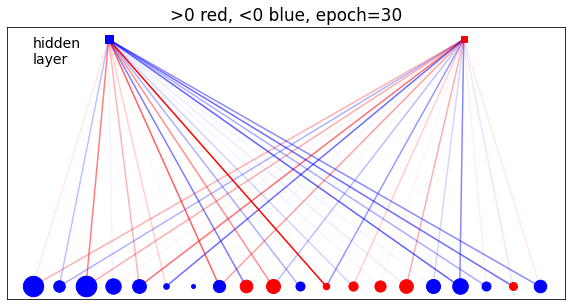

l_rate =  0.7692307692307697
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.11035981 -0.32346331  0.64574045 -0.05865128  0.37823528  0.23339853
  0.02582341  0.80566036 -0.66157803  0.56837183 -0.40982138  1.28989989
 -0.2219992  -0.05743838 -0.10339716 -0.05294359 -0.80352901 -0.42658918
 -0.74106389 -0.5940217 ]
EVALUATED ENERGIES =  [-0.39594144 -0.1943089   0.         -1.31176037] 

PROBABILITY :  [0.20043044 0.16383089 0.13489893 0.50083975] 

CUMULATIVE PROBABILITY :  [0.20043044 0.36426133 0.49916025 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.11035981 -0.32346331  0.64574045 -0.05865128  0.37823528  0.23339853
  0.02582341  0.80566036 -0.66157803  0.56837183 -0.40982138  1.28989989
 -0.2219992  -0.05743838 -0.10339716 -0.05294359 -0.80352901 -0.42658918
 -0.74106389 -0.5940217 ]
EVALUATED ENERGIES =  [ 0.         -0.84969665  0.2478227  -0.54746966] 

PROBABILITY :  [0.17098962 0.39993398 0.13345711 0.2956193 ] 

CUMULATIVE PROBABILITY

----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.12506408 -0.32356175  0.63120142 -0.06212502  0.36236255  0.21646009
  0.03676762  0.83138791 -0.64651418  0.56044884 -0.42103017  1.28362711
 -0.24829413 -0.07239185 -0.09663486 -0.02463212 -0.78723054 -0.41036659
 -0.75870403 -0.60718319]
EVALUATED ENERGIES =  [ 0.          0.         -1.62624716 -1.88720439] 

PROBABILITY :  [0.07306926 0.07306926 0.37153939 0.48232209] 

CUMULATIVE PROBABILITY :  [0.07306926 0.14613852 0.51767791 1.        ] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.12529413 -0.32355836  0.63096505 -0.06211548  0.36186532  0.21615882
  0.03702227  0.83196747 -0.6462805   0.56042414 -0.42115827  1.2833804
 -0.24890675 -0.0726334  -0.09645845 -0.02408137 -0.78690656 -0.41002586
 -0.75901424 -0.60746668]
EVALUATED ENERGIES =  [ 0.          0.          0.         -0.22883086] 

PROBABILITY :  [0.23490007 0.23490007 0.23490007 0.29529979] 

CUMULATIVE PROBABILITY :  [0.23490007 0.46980014 

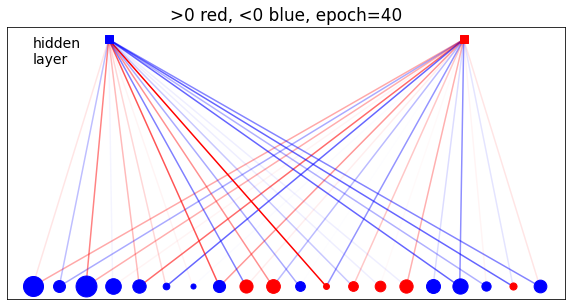

l_rate =  0.7142857142857149
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 1.31896679e-01 -3.26985540e-01  6.20542132e-01 -5.31099587e-02
  3.44233282e-01  2.00624304e-01  5.54432972e-02  8.54447832e-01
 -6.37512304e-01  5.54164071e-01 -4.26303004e-01  1.27833705e+00
 -2.74532809e-01 -8.47708504e-02 -8.58648876e-02 -7.14121590e-04
 -7.74149218e-01 -3.97003685e-01 -7.72640968e-01 -6.17317596e-01]
EVALUATED ENERGIES =  [1.07835779 0.81958367 0.08043809 0.        ] 

PROBABILITY :  [0.12582064 0.16298065 0.34130519 0.36989352] 

CUMULATIVE PROBABILITY :  [0.12582064 0.28880129 0.63010648 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 1.31896679e-01 -3.26985540e-01  6.20542132e-01 -5.31099587e-02
  3.44233282e-01  2.00624304e-01  5.54432972e-02  8.54447832e-01
 -6.37512304e-01  5.54164071e-01 -4.26303004e-01  1.27833705e+00
 -2.74532809e-01 -8.47708504e-02 -8.58648876e-02 -7.14121590e-04
 -7.74149218e-01 -3.97003685e-01 -7.72640968e-01 -6.17317596e-01]
E

----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.13422929 -0.32931934  0.61178961 -0.04240195  0.31773932  0.18828724
  0.06505669  0.88022344 -0.63366352  0.54752928 -0.43043087  1.27812135
 -0.30259961 -0.09584938 -0.07673827  0.02250644 -0.7653564  -0.37853106
 -0.78566587 -0.62714163]
EVALUATED ENERGIES =  [ 0.          0.696669   -1.57487823  0.        ] 

PROBABILITY :  [0.13645552 0.06798789 0.65910107 0.13645552] 

CUMULATIVE PROBABILITY :  [0.13645552 0.20444341 0.86354448 1.        ] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.13430187 -0.32941235  0.6116323  -0.04219665  0.31710597  0.18799779
  0.06538577  0.880832   -0.63359049  0.54742459 -0.43050763  1.2781277
 -0.30304608 -0.09612206 -0.07647875  0.02297772 -0.76521133 -0.37802441
 -0.78594868 -0.62731787]
EVALUATED ENERGIES =  [ 1.34105006 -0.69834102  0.         -0.03449626] 

PROBABILITY :  [0.06073039 0.46676936 0.23217566 0.2403246 ] 

CUMULATIVE PROBABILITY :  [0.06073039 0.52749974 

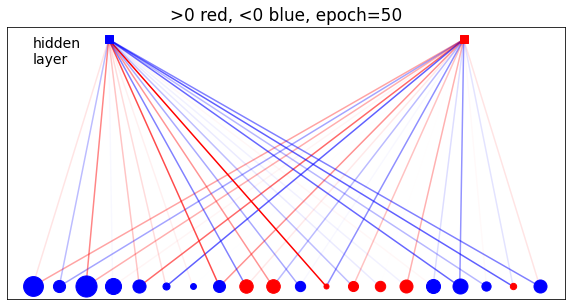

l_rate =  0.6666666666666671
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.13332673 -0.33473154  0.6060454  -0.03396413  0.29382985  0.17678571
  0.07760663  0.8992092  -0.63147372  0.53634795 -0.43130842  1.27747564
 -0.32766175 -0.10501066 -0.07206572  0.04182451 -0.75953536 -0.3599689
 -0.79834941 -0.63567728]
EVALUATED ENERGIES =  [ 0.65823791 -0.87646163  0.          0.        ] 

PROBABILITY :  [0.10523321 0.48827487 0.20324596 0.20324596] 

CUMULATIVE PROBABILITY :  [0.10523321 0.59350808 0.79675404 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.13332673 -0.33473154  0.6060454  -0.03396413  0.29382985  0.17678571
  0.07760663  0.8992092  -0.63147372  0.53634795 -0.43130842  1.27747564
 -0.32766175 -0.10501066 -0.07206572  0.04182451 -0.75953536 -0.3599689
 -0.79834941 -0.63567728]
EVALUATED ENERGIES =  [ 1.15746963  0.          0.06739072 -0.01310259] 

PROBABILITY :  [0.0963371  0.30653229 0.28655554 0.31057508] 

CUMULATIVE PROBABILITY :

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.12362489 -0.34927895  0.59701106 -0.01814166  0.26913066  0.15660765
  0.08550119  0.92446043 -0.64279951  0.51883058 -0.42534331  1.27948298
 -0.35684716 -0.1172631  -0.06675701  0.06504723 -0.76150539 -0.33983692
 -0.81700532 -0.64577586]
EVALUATED ENERGIES =  [-0.54682305 -0.38648062  0.         -1.20613652] 

PROBABILITY :  [0.2291422  0.19519525 0.13262422 0.44303832] 

CUMULATIVE PROBABILITY :  [0.2291422  0.42433746 0.55696168 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.12256037 -0.3495997   0.59419223 -0.01702348  0.26393969  0.15248795
  0.09026355  0.92728015 -0.64620369  0.51464803 -0.4249958   1.28288472
 -0.36069281 -0.12054904 -0.06751311  0.06926222 -0.7601127  -0.33757349
 -0.82108943 -0.64747213]
EVALUATED ENERGIES =  [-0.54794906 -0.65569436  0.09627743 -1.27141892] 

PROBABILITY :  [0.21274754 0.23695056 0.11170704 0.43859485] 

CUMULATIVE PROBABILITY :  [0.21274754 0.44969811 0

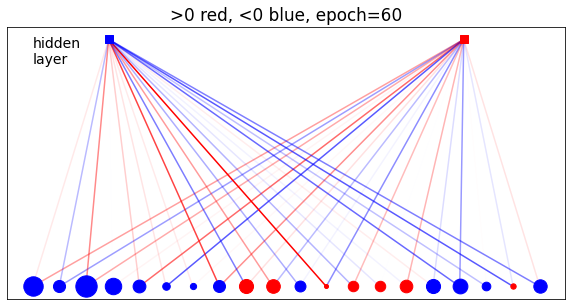

l_rate =  0.6250000000000006
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.10889193 -0.34875343  0.5903213  -0.00346057  0.24638819  0.13451872
  0.10582238  0.9468662  -0.65652803  0.50400452 -0.41278845  1.28835645
 -0.37811273 -0.13202559 -0.06348923  0.08907772 -0.75778877 -0.3233808
 -0.83795328 -0.64925308]
EVALUATED ENERGIES =  [ 0.          0.         -0.18387985  0.21948035] 

PROBABILITY :  [0.2496999  0.2496999  0.30010717 0.20049302] 

CUMULATIVE PROBABILITY :  [0.2496999  0.4993998  0.79950698 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.10889193 -0.34875343  0.5903213  -0.00346057  0.24638819  0.13451872
  0.10582238  0.9468662  -0.65652803  0.50400452 -0.41278845  1.28835645
 -0.37811273 -0.13202559 -0.06348923  0.08907772 -0.75778877 -0.3233808
 -0.83795328 -0.64925308]
EVALUATED ENERGIES =  [ 0.          0.05757638  0.10448182 -0.35748074] 

PROBABILITY :  [0.23394199 0.22085288 0.21073288 0.33447225] 

CUMULATIVE PROBABILITY :

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.0902052  -0.35489827  0.59081637  0.02200646  0.22681329  0.11493081
  0.11954204  0.97199832 -0.67477343  0.48644537 -0.39360044  1.30733761
 -0.40021334 -0.14462796 -0.05157097  0.11214504 -0.75582989 -0.30441951
 -0.85667955 -0.64953864]
EVALUATED ENERGIES =  [ 0.71525162  0.          0.         -0.64643402] 

PROBABILITY :  [0.11120788 0.22738687 0.22738687 0.43401837] 

CUMULATIVE PROBABILITY :  [0.11120788 0.33859475 0.56598163 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.0875451  -0.35442131  0.59042392  0.02669827  0.224351    0.11173275
  0.12311291  0.97506496 -0.67880336  0.48396707 -0.38892125  1.31062252
 -0.40444427 -0.14502583 -0.04951752  0.11612097 -0.75321036 -0.30171836
 -0.86104783 -0.64839185]
EVALUATED ENERGIES =  [-0.93140193  0.04305993 -0.11904605  0.        ] 

PROBABILITY :  [0.45142495 0.1703657  0.20034748 0.17786187] 

CUMULATIVE PROBABILITY :  [0.45142495 0.62179065 0

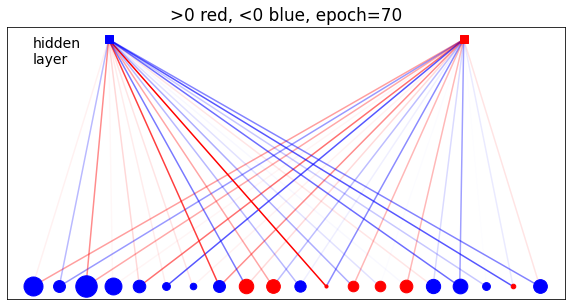

l_rate =  0.5882352941176475
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.07123903 -0.36157031  0.59660675  0.04376882  0.2019117   0.09833212
  0.1381873   0.99361153 -0.69474538  0.46875582 -0.36842648  1.32248617
 -0.42315435 -0.15371919 -0.03767477  0.13228768 -0.75770128 -0.29179135
 -0.86954299 -0.6450342 ]
EVALUATED ENERGIES =  [ 0.          0.69222869  0.         -0.11165496] 

PROBABILITY :  [0.276351   0.13830247 0.276351   0.30899552] 

CUMULATIVE PROBABILITY :  [0.276351   0.41465348 0.69100448 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.07123903 -0.36157031  0.59660675  0.04376882  0.2019117   0.09833212
  0.1381873   0.99361153 -0.69474538  0.46875582 -0.36842648  1.32248617
 -0.42315435 -0.15371919 -0.03767477  0.13228768 -0.75770128 -0.29179135
 -0.86954299 -0.6450342 ]
EVALUATED ENERGIES =  [-0.21545895 -0.40538278  0.          0.59592045] 

PROBABILITY :  [0.28905295 0.34951055 0.23302621 0.12841029] 

CUMULATIVE PROBABILITY

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.04806375 -0.3741218   0.60645423  0.06757178  0.17971565  0.08020299
  0.15546149  1.01655626 -0.71769021  0.45290158 -0.34641906  1.33842593
 -0.4493199  -0.15781064 -0.02633111  0.15334173 -0.7686907  -0.27784928
 -0.87955395 -0.64359341]
EVALUATED ENERGIES =  [ 0.          0.         -0.23142851 -0.06363821] 

PROBABILITY :  [0.23115476 0.23115476 0.29134728 0.24634319] 

CUMULATIVE PROBABILITY :  [0.23115476 0.46230952 0.75365681 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.04494954 -0.37642685  0.60822636  0.07122007  0.17604717  0.07675076
  0.1594983   1.01989668 -0.72073761  0.44863283 -0.34203552  1.34117724
 -0.45297894 -0.16024673 -0.02451635  0.15831092 -0.76891412 -0.27424004
 -0.88302843 -0.64304968]
EVALUATED ENERGIES =  [-0.3834367  -0.0836399   0.33824355  0.        ] 

PROBABILITY :  [0.34382941 0.25476685 0.16707877 0.23432497] 

CUMULATIVE PROBABILITY :  [0.34382941 0.59859626 0

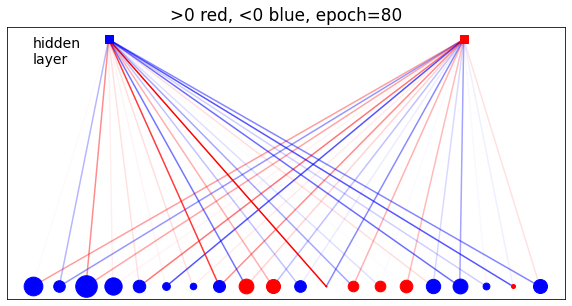

l_rate =  0.555555555555556
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 0.02577106 -0.38675325  0.61046289  0.08947443  0.15632277  0.05871092
  0.17192551  1.03824288 -0.7376615   0.43123215 -0.32554674  1.35090182
 -0.47294826 -0.16728759 -0.01670479  0.17427328 -0.77590236 -0.26206172
 -0.8950625  -0.64696053]
EVALUATED ENERGIES =  [ 0.92010415  0.          0.         -1.93511029] 

PROBABILITY :  [0.04274004 0.10725833 0.10725833 0.74274331] 

CUMULATIVE PROBABILITY :  [0.04274004 0.14999836 0.25725669 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [ 0.02577106 -0.38675325  0.61046289  0.08947443  0.15632277  0.05871092
  0.17192551  1.03824288 -0.7376615   0.43123215 -0.32554674  1.35090182
 -0.47294826 -0.16728759 -0.01670479  0.17427328 -0.77590236 -0.26206172
 -0.8950625  -0.64696053]
EVALUATED ENERGIES =  [-0.43675925 -1.64450724 -1.21231646  0.57219025] 

PROBABILITY :  [0.14529932 0.48616295 0.31556134 0.05297639] 

CUMULATIVE PROBABILITY 

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [ 0.00529928 -0.39295323  0.621148    0.11225847  0.1315033   0.03920273
  0.19363303  1.06279564 -0.76113544  0.41328174 -0.3015769   1.36894226
 -0.49686068 -0.17892992 -0.00316464  0.1972702  -0.78105185 -0.24586636
 -0.90974424 -0.64522629]
EVALUATED ENERGIES =  [ 0.         -0.82809666 -0.95952697  0.        ] 

PROBABILITY :  [0.14493973 0.33176095 0.37835958 0.14493973] 

CUMULATIVE PROBABILITY :  [0.14493973 0.47670069 0.85506027 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [ 8.81675756e-04 -3.94421640e-01  6.20956295e-01  1.15535483e-01
  1.27289058e-01  3.53017111e-02  1.96825947e-01  1.06631875e+00
 -7.65488854e-01  4.10067561e-01 -2.99409723e-01  1.37326642e+00
 -5.01184735e-01 -1.80039108e-01 -1.08032729e-03  2.00509447e-01
 -7.80688502e-01 -2.42920793e-01 -9.14202710e-01 -6.46711698e-01]
EVALUATED ENERGIES =  [-0.6094498   0.          0.51939201 -0.44439314] 

PROBABILITY :  [0.36833726 0.200

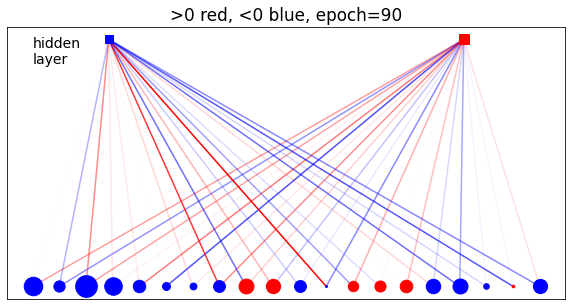

l_rate =  0.5263157894736847
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-0.01695793 -0.40062776  0.62776003  0.13277986  0.11035002  0.01958149
  0.21221823  1.08383932 -0.78276704  0.39653997 -0.28164067  1.38916814
 -0.51875028 -0.18765402  0.0102885   0.21784359 -0.78920317 -0.2309518
 -0.92438852 -0.64167269]
EVALUATED ENERGIES =  [0.         0.         0.         0.67021491] 

PROBABILITY :  [0.28477059 0.28477059 0.28477059 0.14568824] 

CUMULATIVE PROBABILITY :  [0.28477059 0.56954117 0.85431176 1.        ] 


----initiating backward CD: k =  500 ----
WEIGHTS[0] :  [-0.01695793 -0.40062776  0.62776003  0.13277986  0.11035002  0.01958149
  0.21221823  1.08383932 -0.78276704  0.39653997 -0.28164067  1.38916814
 -0.51875028 -0.18765402  0.0102885   0.21784359 -0.78920317 -0.2309518
 -0.92438852 -0.64167269]
EVALUATED ENERGIES =  [ 0.         -0.56503292 -0.99551499  0.        ] 

PROBABILITY :  [0.15466413 0.27213242 0.41853932 0.15466413] 

CUMULATIVE PROBABILITY :  [0

----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-0.04003867 -0.41715233  0.63741111  0.15496566  0.08820044  0.00307095
  0.22792615  1.10335002 -0.80444469  0.37603913 -0.25966487  1.4063901
 -0.54035154 -0.19776199  0.01970658  0.23668382 -0.80478637 -0.22025355
 -0.93921986 -0.6346695 ]
EVALUATED ENERGIES =  [0.         0.32063956 0.04867627 0.        ] 

PROBABILITY :  [0.27187402 0.19729483 0.25895713 0.27187402] 

CUMULATIVE PROBABILITY :  [0.27187402 0.46916885 0.72812598 1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-4.38587175e-02 -4.18936084e-01  6.38812477e-01  1.58792524e-01
  8.42690766e-02  7.49156272e-04  2.31782826e-01  1.10591385e+00
 -8.08709550e-01  3.71190454e-01 -2.54783715e-01  1.41039473e+00
 -5.45146526e-01 -2.00907750e-01  2.25357591e-02  2.41622274e-01
 -8.05056958e-01 -2.18518808e-01 -9.41752708e-01 -6.34268357e-01]
EVALUATED ENERGIES =  [ 0.          0.          0.55629073 -1.12514396] 

PROBABILITY :  [0.17686618 0.17686618

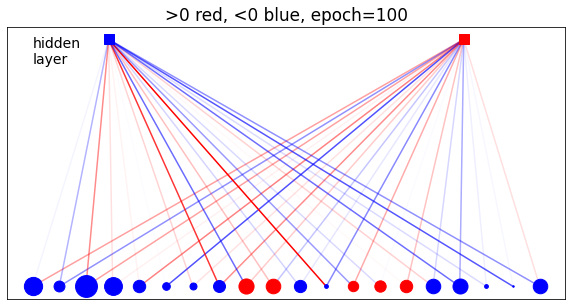

l_rate =  0.5000000000000009


In [8]:
# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

# learning rate
l_rate = 1.0

# initialize Adam 
beta1=0.9
beta2=0.999
epsilon=1e-8
m_dw, v_dw = 0, 0
m_db, v_db = 0, 0
m_da, v_da = 0, 0

beta=0.9

t=1

#energies
E_rbm = np.zeros(100)
E_d = np.zeros(100)

# minibatch
mini, m = 1000, 0
steps=3
# train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        hf = h
        vf = v[k]
        for i in range(steps):
            vf,_ = activate_back(vf,hf,w,a,k,i)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b,GAP)
        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model+= np.outer(vf.T,hf)
        
        # update energies of the state for each row
        E_rbm[epoch] += E(vf,h)
        E_d[epoch] += E(v[k],h)
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a Adam optimizer
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)       
            db = l_rate_m*(h_data - h_model)
            
            if epoch<=50: #ADAM
                ##********update***********##
                m_dw = beta1*m_dw + (1-beta1)*(vh_data - vh_model)
                m_db = beta1*m_db + (1-beta1)*(h_data - h_model)
                m_da = beta1*m_da + (1-beta1)*(v_data - v_model)

                ## rms beta 2
                v_dw = beta2*v_dw + (1-beta2)*((vh_data - vh_model)**2)
                v_db = beta2*v_db + (1-beta2)*((h_data - h_model)**2)
                v_da = beta2*v_da + (1-beta2)*((v_data - v_model)**2)

                ## bias correction
                m_dw_corr = m_dw/(1-beta1**t)
                m_db_corr = m_db/(1-beta1**t)
                m_da_corr = m_da/(1-beta1**t)

                v_dw_corr = v_dw/(1-beta2**t)
                v_db_corr = v_db/(1-beta2**t)
                v_da_corr = v_da/(1-beta2**t)
            
                ## update weights and biases
                w = w - l_rate_m*(m_dw_corr/(np.sqrt(v_dw_corr)+epsilon))
                b = b - l_rate_m*(m_db_corr/(np.sqrt(v_db_corr)+epsilon))
                a = a - l_rate_m*(m_da_corr/(np.sqrt(v_da_corr)+epsilon))
                m=0
                t=t+1 #update the time
                
            else: #RMSprop
                v_dw = beta*v_dw + (1-beta)*((vh_data - vh_model)**2)
                v_db = beta*v_db + (1-beta)*((h_data - h_model)**2)
                v_da = beta*v_da + (1-beta)*((v_data - v_model)**2)
                w = w - l_rate_m*((vh_data - vh_model)/(np.sqrt(v_dw+epsilon)))
                b = b - l_rate_m*((h_data - h_model)/(np.sqrt(v_db+epsilon)))
                a = a - l_rate_m*((v_data - v_model)/(np.sqrt(v_da+epsilon)))

                m=0
            
            if epoch%10==9 and k<=mini:
                print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                print('dw =',dw)
                print('da =',da)
                print('db =',db)
                print('vh_data \n', vh_data, '\n')
                print('vh_model \n',vh_model)

    #print('E_rbm = ', E_rbm)
    #print('E_data = ', E_d)
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)


In [72]:
print(vf)

[1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]


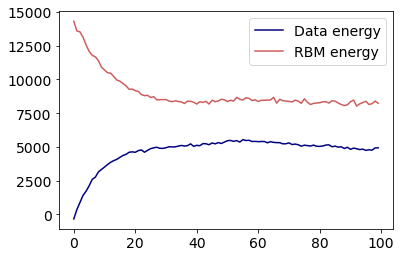

In [9]:
fig, ax = plt.subplots()
ax.plot(np.arange(100), E_d, label='Data energy', color='navy')
ax.plot(np.arange(100), E_rbm, label='RBM energy', color='indianred')
ax.legend(loc='best')

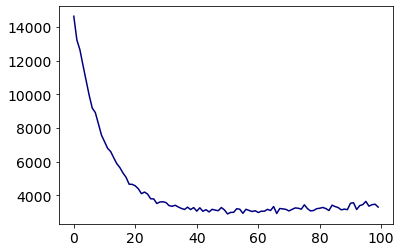

In [10]:
rms = np.sqrt((E_rbm-E_d)**2)
fig, ax = plt.subplots()
ax.plot(np.arange(100), rms, label='rms', color='navy')


# Optional 5. plot the weights 


Plot the weights wiμ of each hidden unit μ
in an A×G table, with a color map preserving the
rule that red means positive and blue
means negative weight

In [20]:
print('w0=',w0);print('a0=',a0);print('b0=',b0)
print('w=',w);print('a=',a);print('b=',b)


w0= [[-8.72876393e-02  2.04222126e-01]
 [-2.21489412e-01 -2.36964198e-01]
 [ 8.38211653e-01  5.94150244e-01]
 [ 3.96160518e-02  1.20136963e-01]
 [ 3.27912325e-01  5.31481557e-01]
 [ 4.29466985e-01 -5.52710538e-01]
 [ 1.17256826e-01  9.76087795e-02]
 [ 5.76885677e-01  3.77974741e-01]
 [-8.53501017e-01 -1.58554191e-01]
 [ 7.11674783e-01 -1.87006764e-01]
 [-2.30146526e-01  2.03387092e-01]
 [ 1.38535434e+00 -4.35452880e-01]
 [-2.46070853e-01  5.29254898e-02]
 [ 1.29034856e-01  2.23337160e-01]
 [ 4.00935791e-04  5.73002421e-01]
 [-3.04256178e-01 -3.54405060e-01]
 [-1.01067017e+00 -7.93431066e-01]
 [-3.67028188e-01  2.38846755e-01]
 [-5.39796281e-01  5.10944576e-02]
 [-4.53483232e-01  1.41941667e-01]]
a0= [-1.00605956 -0.0850854  -0.6575091  -0.41392318 -0.55731957  0.12209994
  0.16117297 -0.3214583   0.14126068  0.57553201  0.02979552  0.10518219
 -0.0050578   0.4284531   0.56591768 -0.39197445 -0.6605412   0.00945954
  0.32336713 -0.28164852]
b0= [0. 0.]
w= [[ -9.90680619  -9.49798202]
 [

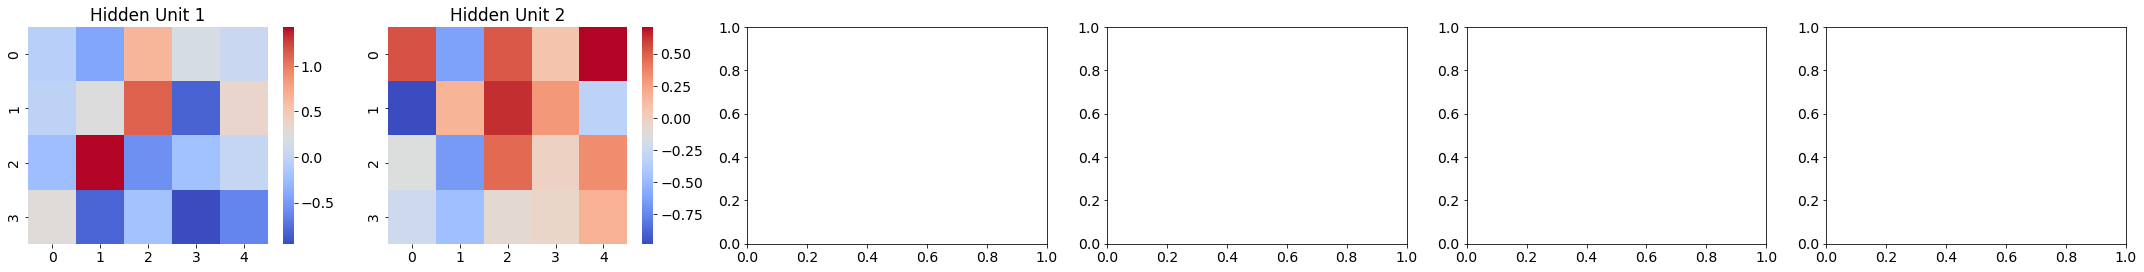

In [11]:
w1=[w[:,i].reshape(4,5) for i in range(M)]
import seaborn as sns

fig, axs = plt.subplots(ncols=6, figsize=(5*6,4))
for i in range(M):
    sns.heatmap(w1[i], cmap='coolwarm', annot=False, ax=axs[i])
    axs[i].set_title(f'Hidden Unit {i+1}')
    plt.tight_layout()
plt.show()

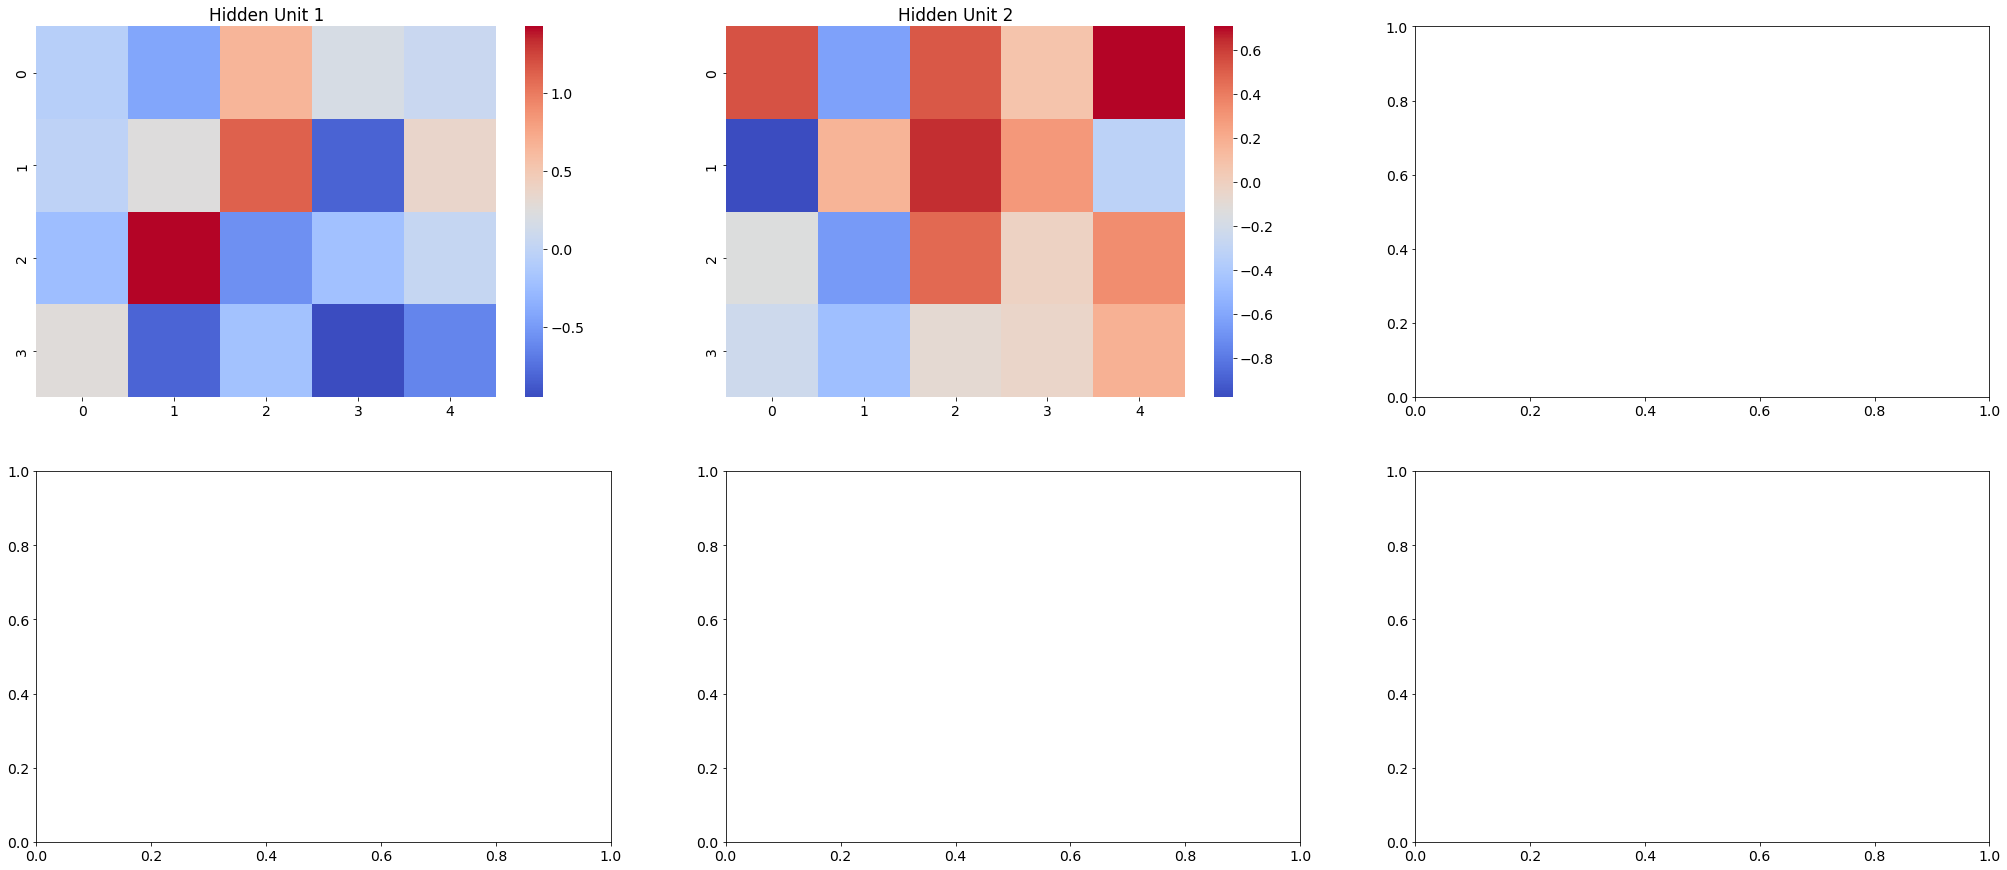

In [12]:
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(35,15))
for i in range(M):
    sns.heatmap(w1[i], cmap='coolwarm', annot=False, ax=axs.flat[i])
    axs.flat[i].set_title(f'Hidden Unit {i+1}')
plt.show()

